In [4]:
import pandas as pd
import torch
import os
import torch.nn as nn
data=pd.read_csv(r"C:\Users\argdi\Desktop\gitProblems\emotions.csv")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

import numpy as np
import torch
y = data['label']
dictLabel = {'POSITIVE': 0, 'NEGATIVE':1, 'NEUTRAL': 2}
yNum = data['label'].map(dictLabel)
x = data.drop(columns = 'label')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x))

x = torch.tensor(x.values, dtype=torch.float32)
y = torch.tensor(yNum.values)

x_train, x_val, y_train, y_val = train_test_split(x, y, train_size = 0.8)


x_train = torch.unsqueeze(x_train, dim=1)
x_val = torch.unsqueeze(x_val, dim=1)

In [5]:

x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)

from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train, y_train)
val_ds = TensorDataset(x_val, y_val)


batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True)  
valid_dl = DataLoader(val_ds, batch_size, shuffle=False)  

class myModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        #convolutional layers
        self.conv1 = nn.Conv1d(in_channels = 1, out_channels = 32, kernel_size = 5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=4)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels= 64, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=4)
        
        self.flat = nn.Flatten()
        
        
        #linear
        self.fc1 = nn.Linear(10176, 1024) #2048
        self.relu5 = nn.ReLU()
        self.drop = nn.Dropout(p = 0.5)

        self.fc2 = nn.Linear(1024, 3)
        
        self.fc3 = nn.Linear(256, 1)
        self.a = nn.Sigmoid()
        
        l = [self.conv1, self.relu1, self.pool1, self.conv2, self.relu2, self.pool2,
            self.flat, self.fc1, self.relu5, self.drop, self.fc2]
        self.module_list = nn.ModuleList(l)
    
    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x

class modelLinear(nn.Module):
    def __init__(self):
        super().__init__()
        

In [6]:
model = myModel().to(device)
model

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
num_epochs = 20

loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_dl:
        
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train[epoch] += loss.item()*batch_size
        is_correct = (torch.argmax(pred, dim=1)== y_batch).float()
        accuracy_hist_train[epoch] += float(is_correct.sum().item())
    loss_hist_train[epoch] /= len(train_dl.dataset)
    accuracy_hist_train[epoch] /= len(train_dl.dataset)

    model.eval()
        
    with torch.no_grad():
        for x_batch, y_batch in valid_dl:
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss_hist_valid[epoch] += loss.item()*batch_size
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_valid[epoch] += float(is_correct.sum().item())
    loss_hist_valid[epoch] /= len(valid_dl.dataset)
    accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
    
    print(f'Epoch {epoch+1} accuracy: '
          f'{accuracy_hist_train[epoch]:.4f} val_accuracy: ' 
          f'{accuracy_hist_valid[epoch]:.4f} loss:'
          f'{loss_hist_train[epoch]:.4f} val_loss:'
          f'{loss_hist_valid[epoch]:.4f}')

Epoch 1 accuracy: 0.6176 val_accuracy: 0.7869 loss:1.0010 val_loss:0.6949
Epoch 2 accuracy: 0.8692 val_accuracy: 0.9110 loss:0.3952 val_loss:0.2682
Epoch 3 accuracy: 0.9214 val_accuracy: 0.9274 loss:0.2088 val_loss:0.2136
Epoch 4 accuracy: 0.9413 val_accuracy: 0.9274 loss:0.1479 val_loss:0.1981
Epoch 5 accuracy: 0.9660 val_accuracy: 0.9649 loss:0.1108 val_loss:0.1289
Epoch 6 accuracy: 0.9707 val_accuracy: 0.9415 loss:0.0921 val_loss:0.1756
Epoch 7 accuracy: 0.9713 val_accuracy: 0.9742 loss:0.0791 val_loss:0.1158
Epoch 8 accuracy: 0.9801 val_accuracy: 0.9766 loss:0.0582 val_loss:0.0916
Epoch 9 accuracy: 0.9889 val_accuracy: 0.9578 loss:0.0434 val_loss:0.1438
Epoch 10 accuracy: 0.9836 val_accuracy: 0.9789 loss:0.0430 val_loss:0.0734
Epoch 11 accuracy: 0.9971 val_accuracy: 0.9766 loss:0.0210 val_loss:0.0762
Epoch 12 accuracy: 0.9965 val_accuracy: 0.9789 loss:0.0153 val_loss:0.0643
Epoch 13 accuracy: 0.9971 val_accuracy: 0.9742 loss:0.0124 val_loss:0.0872
Epoch 14 accuracy: 0.9953 val_accu

In [21]:
from sklearn.metrics import classification_report
import torch.nn.functional as F

model.to(torch.device('cpu'))
x_val = x_val.to(torch.device('cpu'))
y_val = y_val.to(torch.device('cpu'))
pred = model(x_val)

predicted_labels = torch.argmax(F.softmax(pred, dim=1), dim=1).numpy()
#loss = loss_fn(pred, y_val)
#labels = 
#is_correct = (torch.argmax(pred, dim=1) == y_val).float()
#accuracy = is_correct.mean()
#predBin = (pred>0.5).numpy()
report = classification_report(y_val.numpy(), predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       153
           1       0.98      0.98      0.98       127
           2       0.99      0.97      0.98       147

    accuracy                           0.98       427
   macro avg       0.98      0.98      0.98       427
weighted avg       0.98      0.98      0.98       427



[Text(0, 0.5, 'positive'), Text(0, 1.5, 'negative'), Text(0, 2.5, 'neutral')]

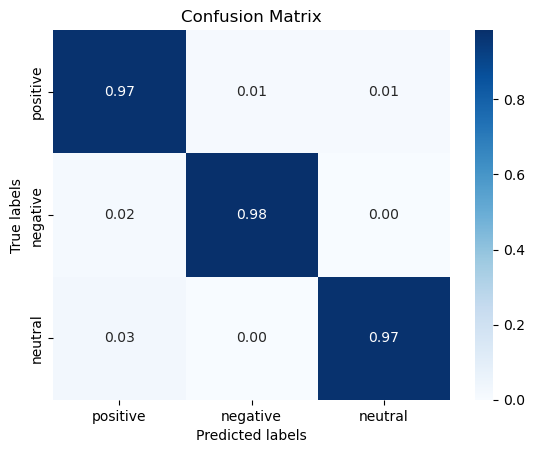

In [20]:
from sklearn.metrics import confusion_matrix
classes = ['positive', 'negative', 'neutral']
cm = confusion_matrix(y_val.numpy(), predicted_labels)
cmNorm = cm.astype(float)/cm.sum(axis=1)[:, np.newaxis]
cmNorm

import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.heatmap(cmNorm, annot=True, cmap='Blues', fmt='.2f', xticklabels=classes, yticklabels=classes, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

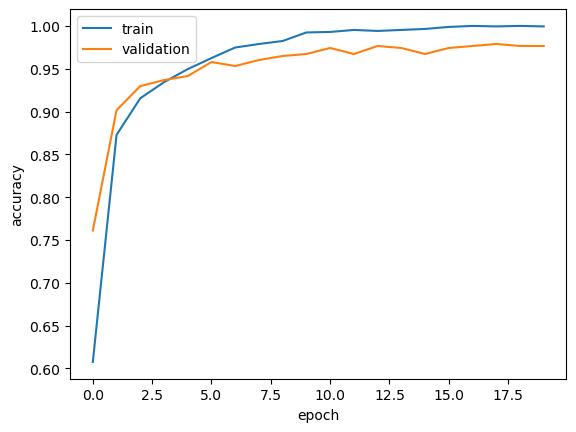

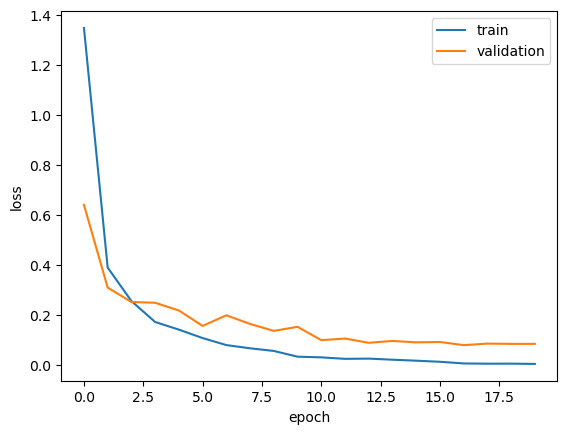

In [22]:

plt.figure(1)
plt.clf()
plt.plot(accuracy_hist_train, label='train')
plt.plot(accuracy_hist_valid, label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure(2)
plt.clf()
plt.plot(loss_hist_train, label = 'train')
plt.plot(loss_hist_valid, label = 'validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()